In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
# import kagglehub
# mateuszbuda_lgg_mri_segmentation_path = kagglehub.dataset_download('mateuszbuda/lgg-mri-segmentation')

# print('Data source import complete.')


In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yosuahares","key":"5022e30b9ac8732c39dfeed67f8b302a"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install -q kaggle

In [4]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 95% 678M/714M [00:06<00:00, 78.9MB/s]
100% 714M/714M [00:06<00:00, 111MB/s] 


In [5]:
ls

lgg-mri-segmentation.zip  sample_data/


In [6]:
!unzip -q lgg-mri-segmentation.zip

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import plotly.express as px

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display


In [8]:
import os
for root, dirs, files in os.walk('.', topdown=True):
    for name in dirs:
        print(os.path.join(root, name))


./.config
./kaggle_3m
./lgg-mri-segmentation
./sample_data
./.config/logs
./.config/configurations
./.config/logs/2025.06.13
./kaggle_3m/TCGA_DU_6405_19851005
./kaggle_3m/TCGA_HT_7856_19950831
./kaggle_3m/TCGA_FG_A4MT_20020212
./kaggle_3m/TCGA_HT_7877_19980917
./kaggle_3m/TCGA_DU_5872_19950223
./kaggle_3m/TCGA_DU_6407_19860514
./kaggle_3m/TCGA_DU_A5TW_19980228
./kaggle_3m/TCGA_DU_6400_19830518
./kaggle_3m/TCGA_HT_8563_19981209
./kaggle_3m/TCGA_DU_5874_19950510
./kaggle_3m/TCGA_HT_7680_19970202
./kaggle_3m/TCGA_HT_7616_19940813
./kaggle_3m/TCGA_DU_8168_19970503
./kaggle_3m/TCGA_HT_8111_19980330
./kaggle_3m/TCGA_FG_A4MU_20030903
./kaggle_3m/TCGA_DU_7013_19860523
./kaggle_3m/TCGA_DU_7018_19911220
./kaggle_3m/TCGA_DU_7299_19910417
./kaggle_3m/TCGA_FG_8189_20030516
./kaggle_3m/TCGA_DU_7008_19830723
./kaggle_3m/TCGA_HT_7884_19980913
./kaggle_3m/TCGA_FG_5964_20010511
./kaggle_3m/TCGA_CS_6290_20000917
./kaggle_3m/TCGA_DU_5871_19941206
./kaggle_3m/TCGA_DU_5853_19950823
./kaggle_3m/TCGA_DU_7309_

# 1. Importing the Dataset

In [10]:
# data_path = '/content/lgg-mri-segmentation/kaggle_3m/'

# mask_files = glob.glob(os.path.join(data_path, '*/*_mask*'))

# # Create brain scan file paths by removing '_mask' from each mask file
# brain_scans = [mask.replace('_mask', '') for mask in mask_files]

# # Print sample results
# print(brain_scans[:10])
# print(mask_files[:10])

import glob
import os
import pandas as pd

image_files = sorted([
    f for f in glob.glob('/content/lgg-mri-segmentation/kaggle_3m/*/*.tif')
    if '_mask' not in f
])

image_paths = []
mask_paths = []

for img in image_files:
    mask = img.replace('.tif', '_mask.tif')
    if os.path.exists(mask):
        image_paths.append(img)
        mask_paths.append(mask)
    else:
        print(f"⚠️ Warning: mask not found for {img}")


## 1.2 Creating the final data frame:¶
In this section we will combine the brain scans with their corresponding 'masks' in a dataframe. Next, we use a function to determine which masks contain a tumor and which masks are empty.

Then we apply the function to the masks in the dataframe and add a column with 0's and 1's, where 0 indicate a mask with no tumor and 1 indicate a mask with a tumor. This dataframe is needed for the classification task, because then the model can get the brain scans as input and train the column with the 0's and 1's as output.

In [11]:
img_df = pd.DataFrame({
    "image_path": image_paths,
    "mask_path": mask_paths
})

print(img_df.head())

                                          image_path  \
0  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
1  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
2  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
3  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
4  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   

                                           mask_path  
0  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...  
1  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...  
2  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...  
3  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...  
4  /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...  


In [12]:
# Make a function that search for the largest pixel value in the masks, because that will indicate if the image have
# a corresponding mask with a tumor or not.
def positive_negative_diagnosis(file_masks):
    mask = cv2.imread(file_masks)
    value = np.max(mask)
    if value > 0:
        return 1
    else:
        return 0

# Apply the function to the masks and return back a column with 1 and zeros, where 0 indicate no tumor and 1 a tumor.
img_df["Tumor"] = img_df["mask_path"].apply(lambda x: positive_negative_diagnosis(x))

In [13]:
img_df # showing the data

image_path  \
0     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
1     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
2     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
3     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
4     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
...                                                 ...   
3924  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
3925  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
3926  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
3927  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
3928  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   

                                              mask_path  Tumor  
0     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...      0  
1     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...      0  
2     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...      1  
3     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...      1  
4     /content/lgg-mri-segmentation/kaggle_3m/TCGA_C...      1  
...                                                 ...    ...  
3924  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...      0  
3925  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...      0  
3926  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...      0  
3927  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...      0  
3928  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...      0  

[3929 rows x 3 columns]

# 2. Data Visualization

In [14]:
# How many non-tumors (0) and tumors (1) are in the data
img_df['Tumor'].value_counts()

Tumor
0    2556
1    1373
Name: count, dtype: int64

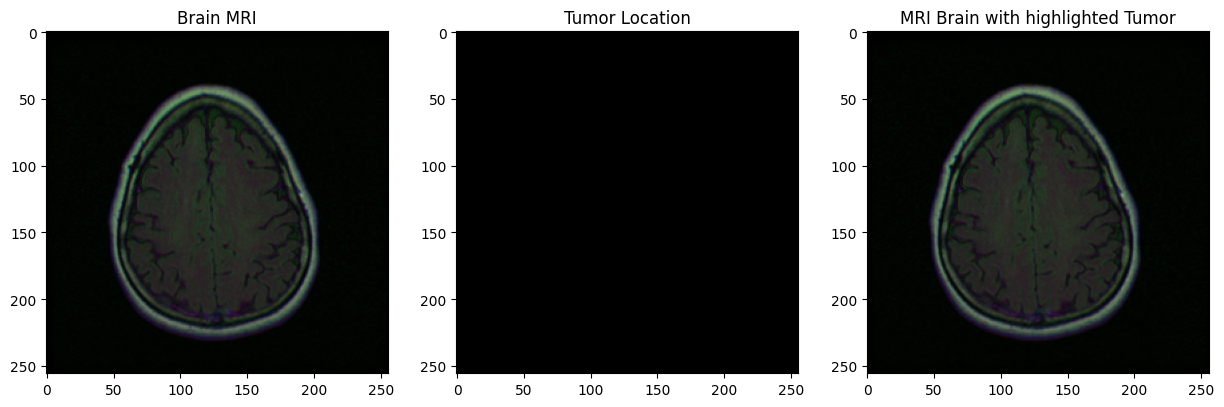

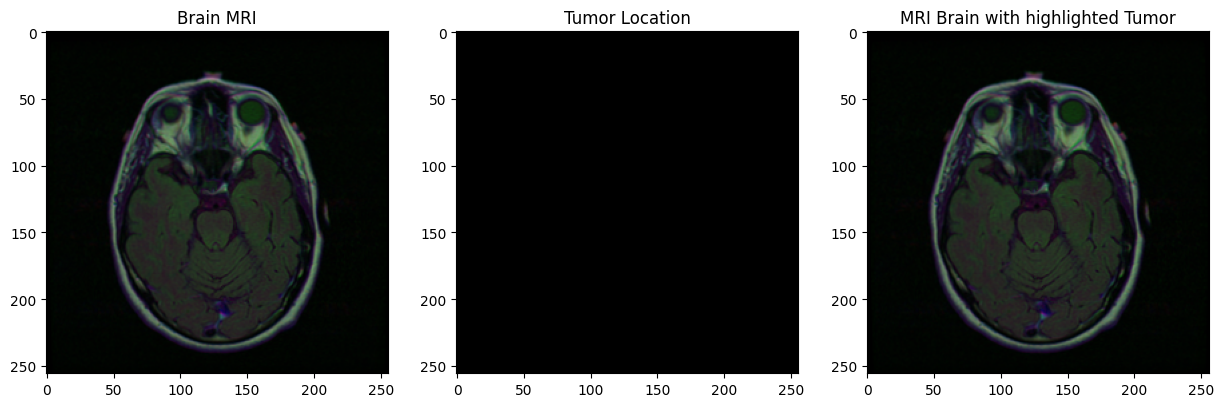

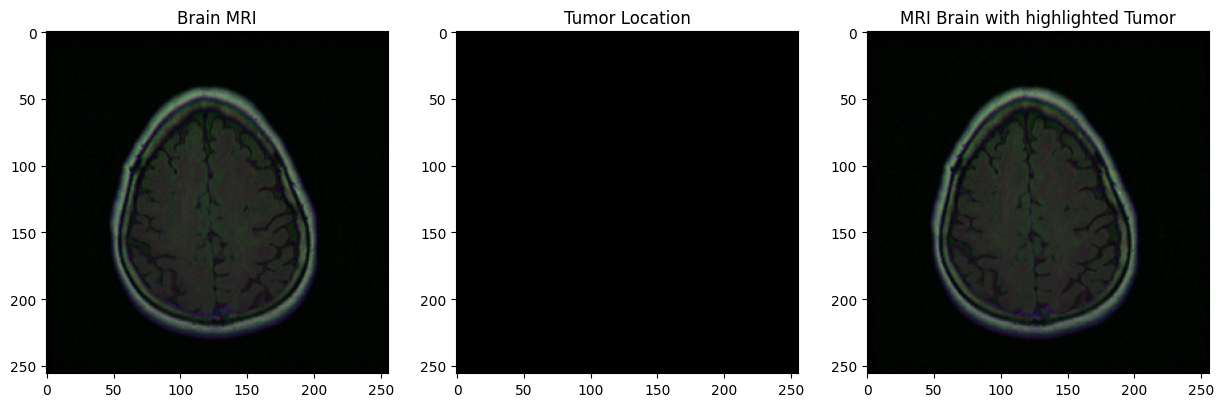

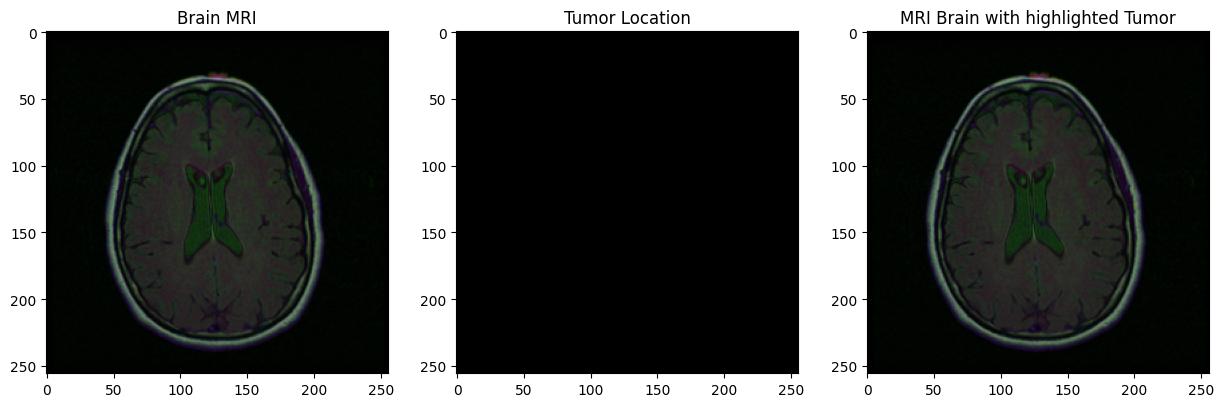

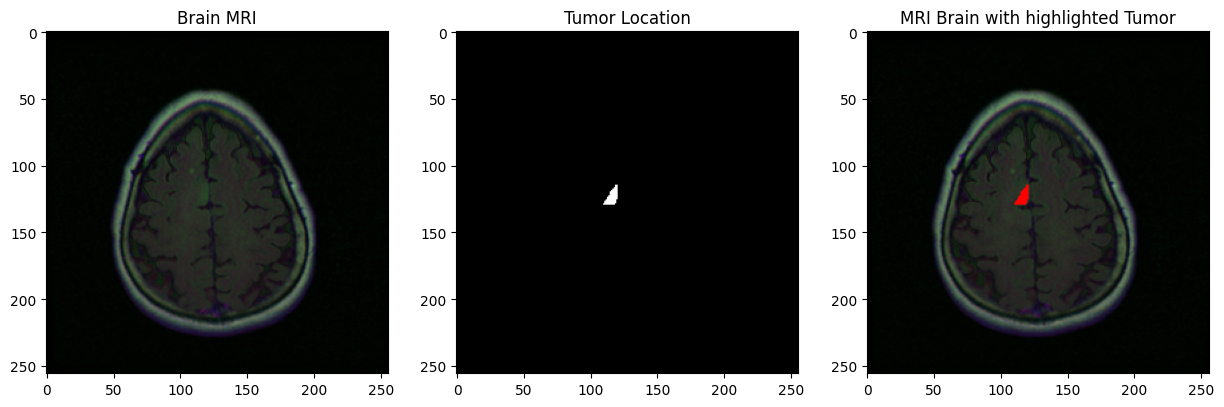

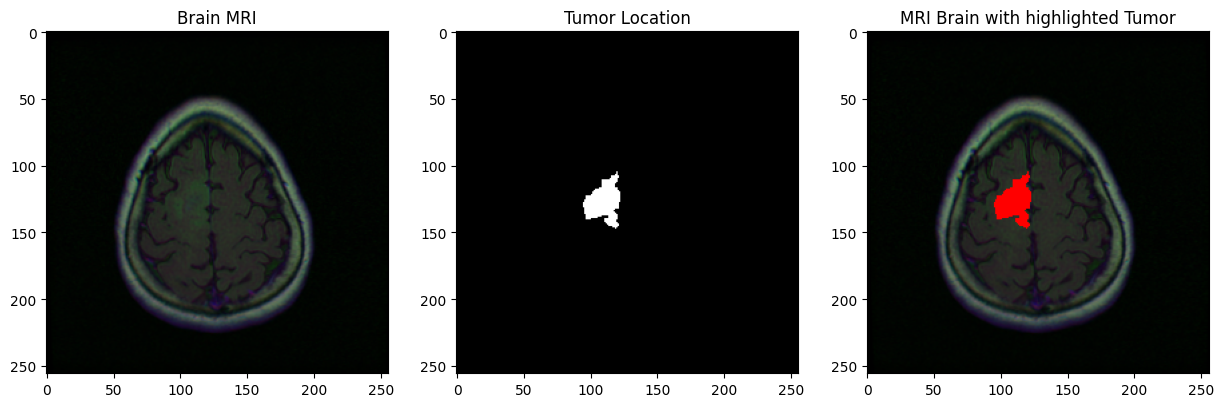

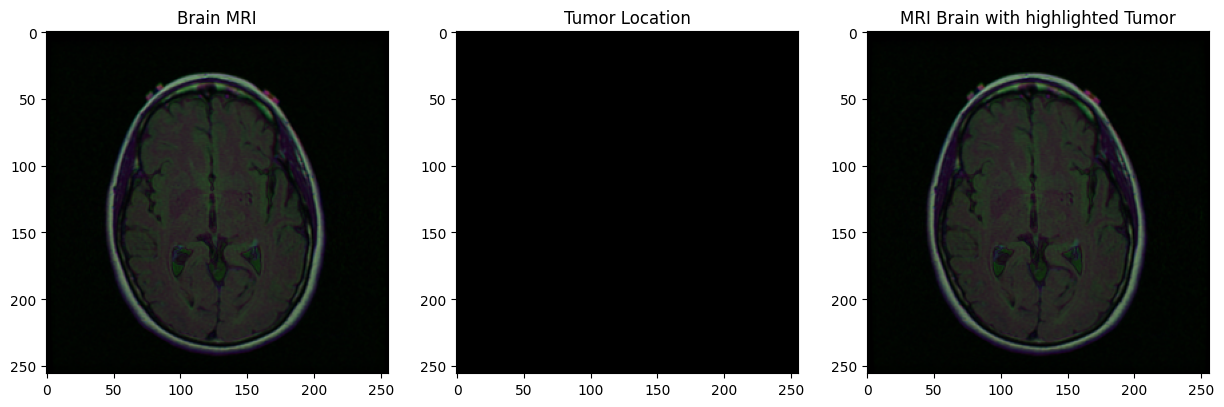

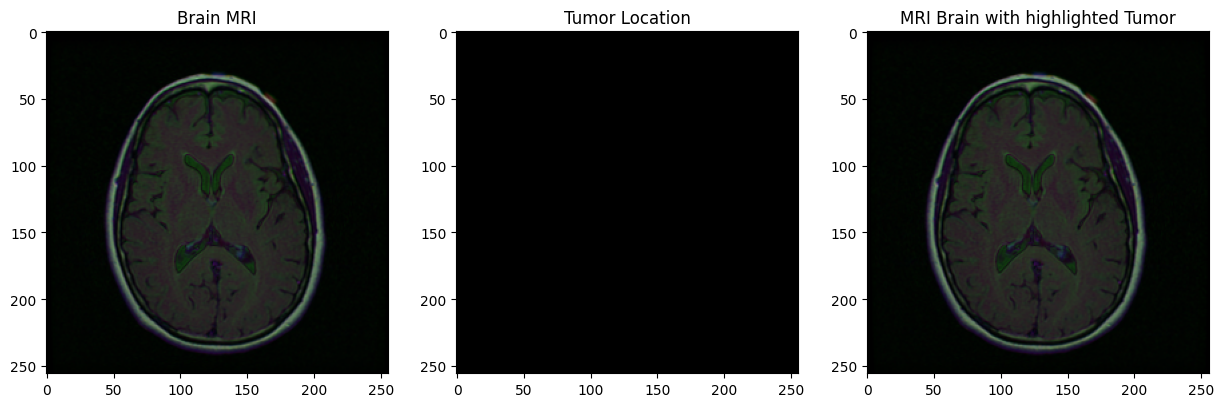

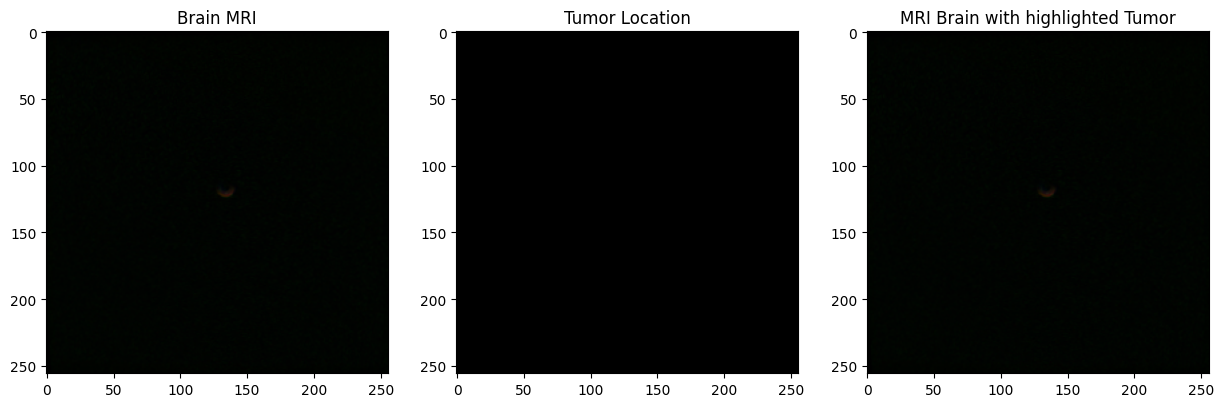

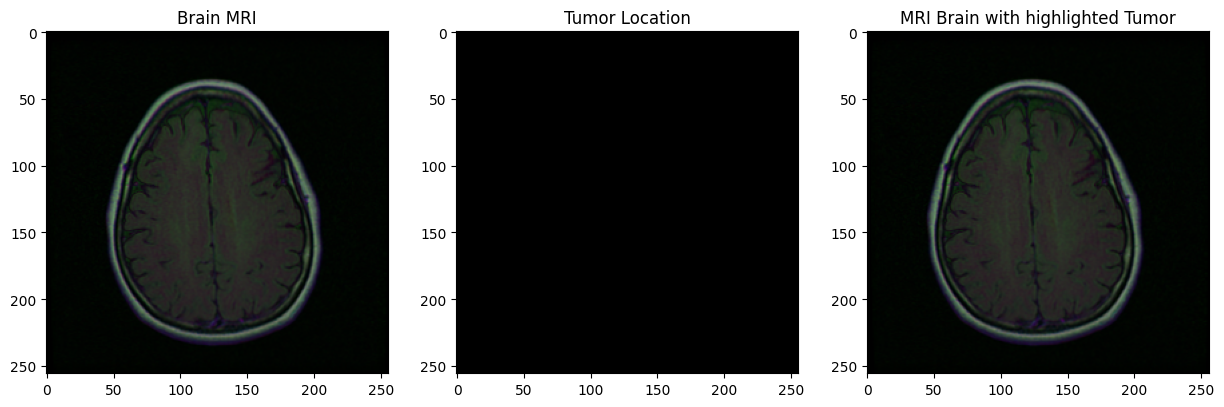

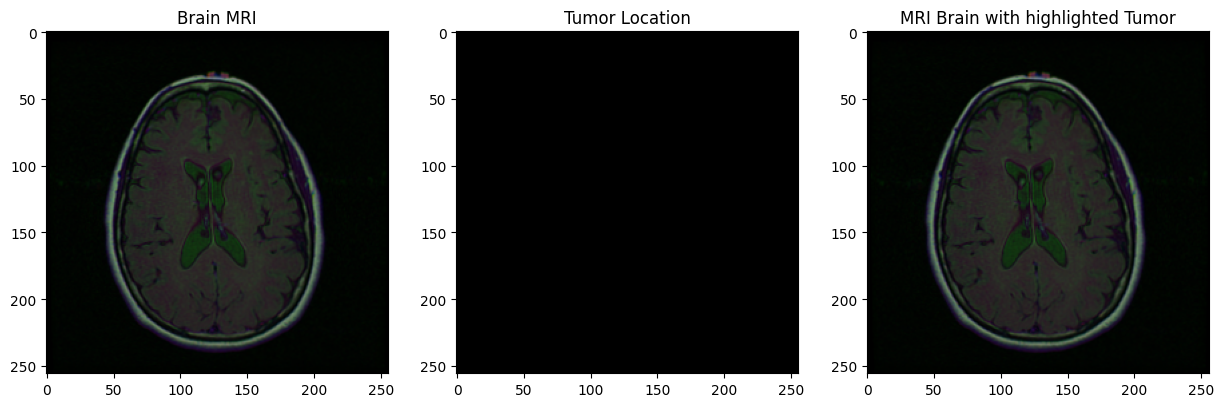

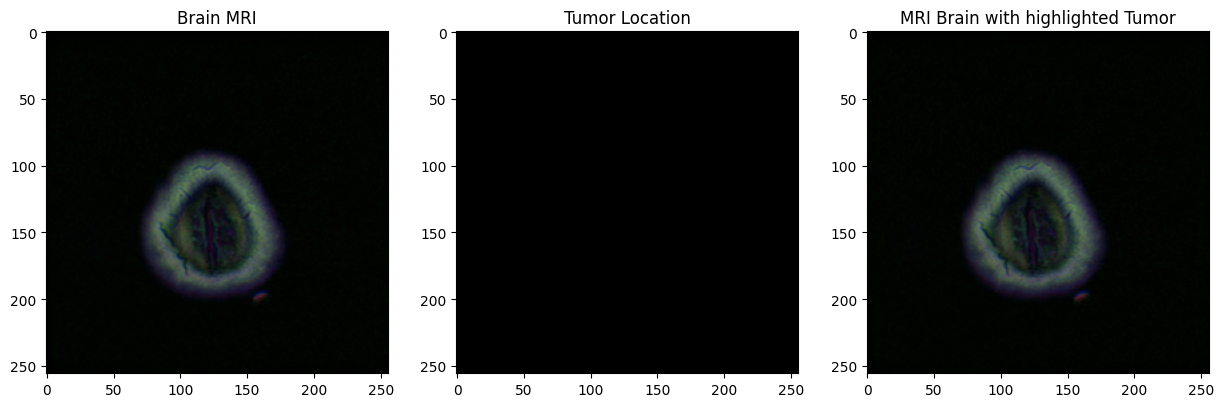

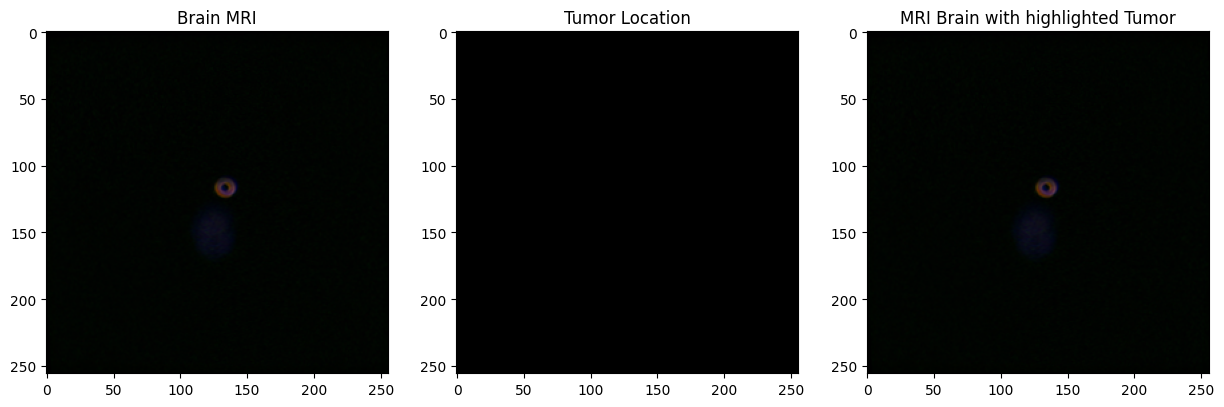

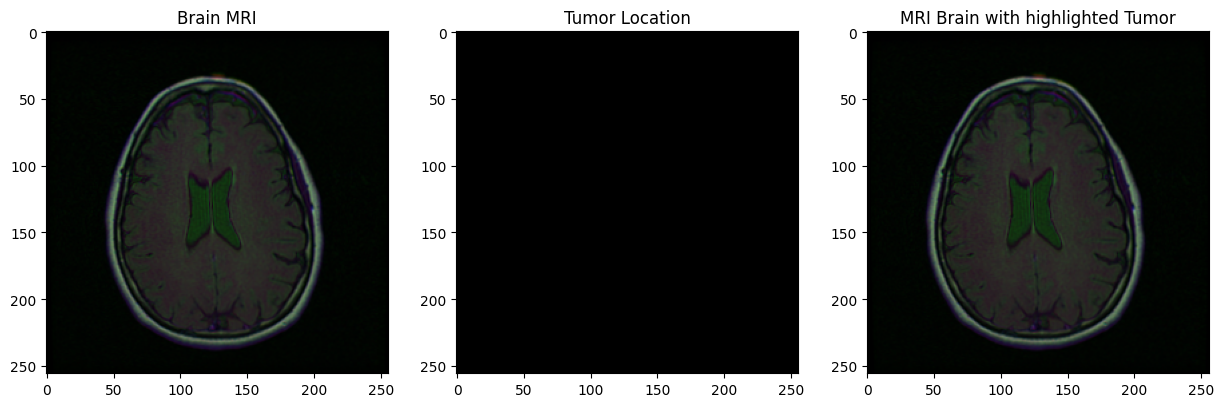

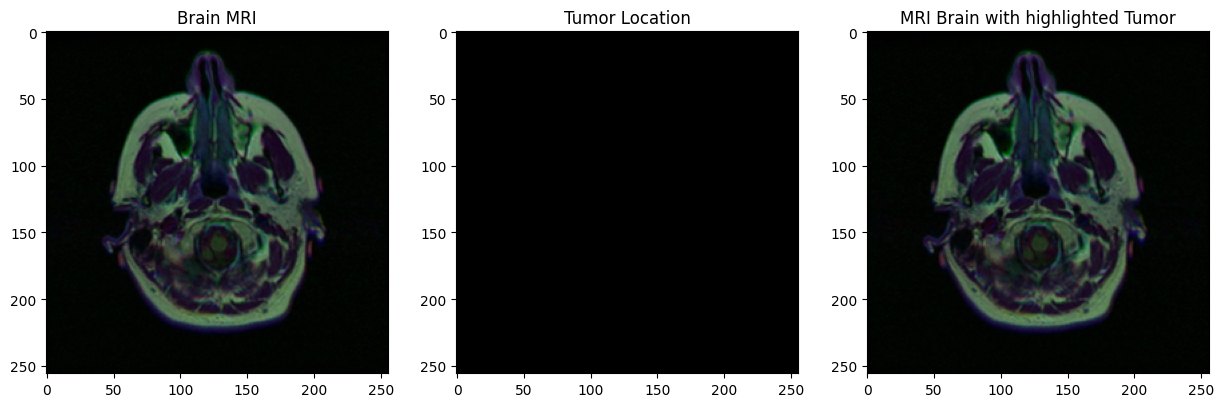

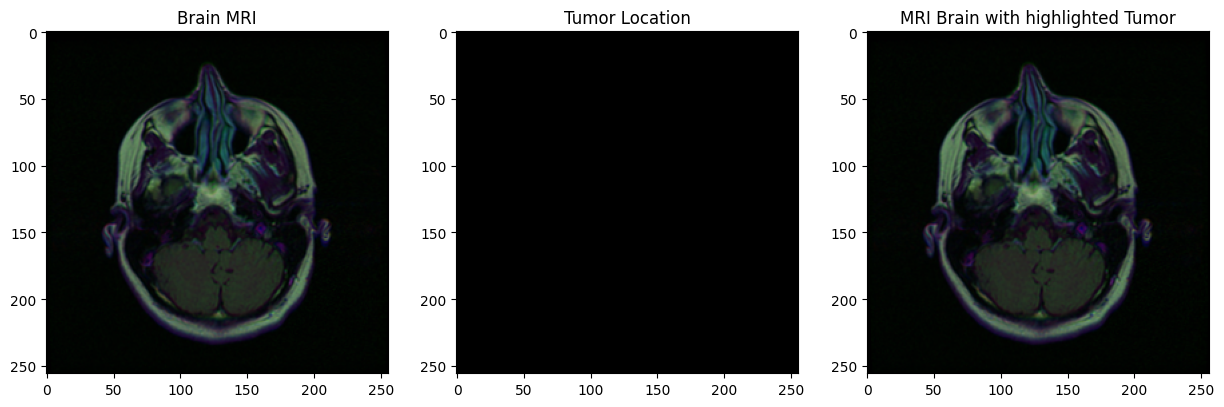

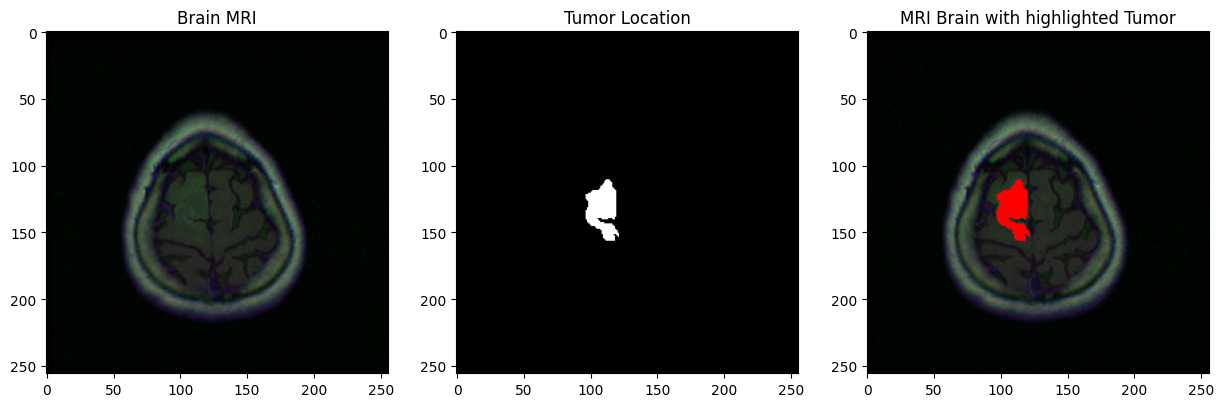

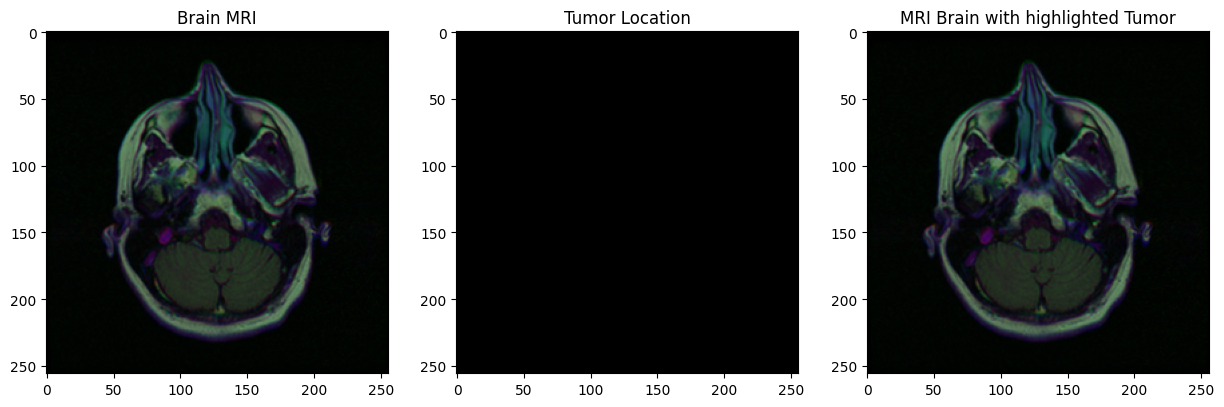

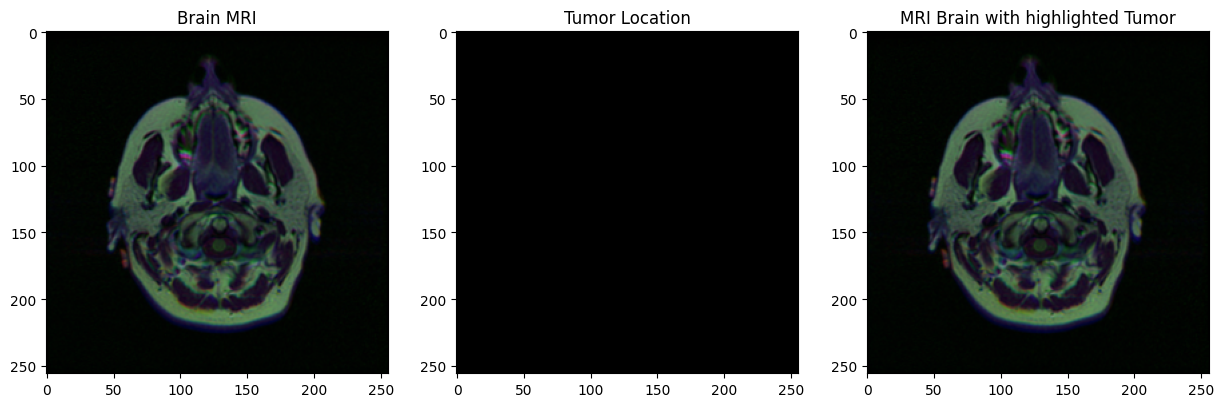

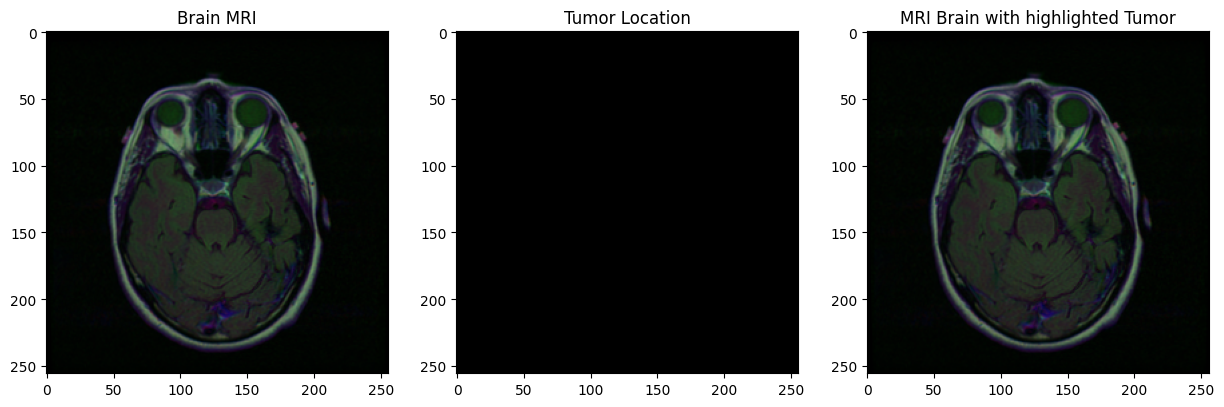

In [15]:
# Data vizualisation
# SOURCE: https://www.kaggle.com/monkira/brain-mri-segmentation-using-unet-keras#Create-data-frame-and-split-data-on-train-set,-validation-set-and-test-set
# https://www.kaggle.com/saivikassingamsetty/brain-tumor-segmentation-with-unet/notebook

for i in range(1,40, 2):
    img_path=brain_scans[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)

    #Plot the Brain MRI scans
    original = img.copy()
    fig, ax = plt.subplots(1,3,figsize = (15,5))
    ax[0].imshow(original)
    ax[0].set_title("Brain MRI")

    # Plot the corresponding mask
    main = original.copy()
    mask = msk.copy()
    ax[1].imshow(mask)
    ax[1].set_title("Tumor Location")

    # Plot the Brain MRI scan with their mask
    main = original.copy()
    label = cv2.imread(msk_path)
    sample = np.array(np.squeeze(label), dtype = np.uint8)
    contours, hier = cv2.findContours(sample[:,:,0],cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_gt = cv2.drawContours(main, contours, -1,[255,0,0], thickness=-1)
    ax[2].imshow(sample_over_gt)
    ax[2].set_title("MRI Brain with highlighted Tumor")

# 3. Spliting Training, Validation and Testing Data from Dataset

In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(img_df,test_size = 0.1)
train, val = train_test_split(train,test_size = 0.2)
print(train.values.shape)
print(val.values.shape)
print(test.values.shape)

train.head()
val.head()

(2828, 3)
(708, 3)
(393, 3)


image_path  \
2274  /content/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
1099  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1177  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3598  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
3424  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   

                                              mask_path  Tumor  
2274  /content/lgg-mri-segmentation/kaggle_3m/TCGA_F...      1  
1099  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...      0  
1177  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...      0  
3598  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...      0  
3424  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...      0

In [17]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
img_df['Tumor'] = img_df['Tumor'].apply(lambda x: str(x))
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   Tumor       3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


# 4. Building a Segmentation Model


## 4.1 Data Augmentation, Genaration, Adjustment

In [18]:
# SOURCE: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

In [19]:
EPOCHS = 80
BATCH_SIZE = 32
im_height = 256
im_width = 256

In [20]:
train_generator_args = dict(width_shift_range=0.05,
                            height_shift_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest'
                           )


train_gen = train_generator(train, BATCH_SIZE,
                            train_generator_args,
                            target_size=(im_height,
                            im_width)
                           )


test_gen = train_generator(val, BATCH_SIZE,
                            dict(),
                            target_size=(im_height, im_width)
                            )

## 4.2 Defineing Loss Function and Metrics
In the code below we see that the maker of this code added a smooth value of 100 to the function of the dice coefficient. The reason for this is that the denominator of the dice coefficient is the sum of the predictions and real values, which can be zero. To avoid division by zero, it's necessary to add an extra value.

Source: https://www.kaggle.com/monkira/brain-mri-segmentation-using-unet-keras

In [21]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [22]:
def unet(input_size=(256,256,3)):

    # Input
    inputs = Input(input_size)

    # Stage 1
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    # Stage 2
    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    # Stage 3
    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    # Stage 4
    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    # Stage 5
    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    # Upstage 1
    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    # Upstage 2
    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    # Upstage 3
    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    # Upstage 4
    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    # Output
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [23]:
model = unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]  

 Total params: 31,043,521 (118.42 MB)

 Trainable params: 31,037,633 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

## 5.1. Setting Hyperparameters and Data Augmentation

In [24]:
# Define reducelr function to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=15,
                              min_delta=0.0001,
                              factor=0.2
                             )

# Define the earltstop function
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              mode='min',
                              verbose=1,
                              patience=20,
                              restore_best_weights = True
                             )

# Defining the Callbacks Function

checkpointer2 = [ModelCheckpoint('unet_brain_mri_seg.keras', verbose=1, save_best_only=True)]
callbacks = [checkpointer2, earlystopping, reduce_lr]

# 6. Training the Model

In [ ]:
# STEP 1: Mount Google Drive to persist checkpoints across sessions
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Define checkpoint directory and path
import os
checkpoint_dir = "/content/drive/MyDrive/colab_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "model_checkpoint.h5")

# STEP 3: Load model from checkpoint if available
from tensorflow.keras.models import load_model

if os.path.exists(checkpoint_path):
    print("🔁 Loading model from last checkpoint...")
    model = load_model(checkpoint_path, custom_objects={
        'dice_coef_loss': dice_coef_loss,
        'iou': iou,
        'dice_coef': dice_coef
    })
else:
    print("🆕 No checkpoint found. Initializing new model...")
    model = unet(input_size=(im_height, im_width, 3))
    model.compile(optimizer='adam', loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

# STEP 4: Define ModelCheckpoint callback
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

# You can add other callbacks here
callbacks = [checkpoint_cb]

# STEP 5: Train model
history = model.fit(
    train_gen,
    steps_per_epoch=len(train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_gen,
    validation_steps=len(val) // BATCH_SIZE,
    callbacks=callbacks
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🆕 No checkpoint found. Initializing new model...
Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_118']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 169s/step - binary_accuracy: 0.8493 - dice_coef: 0.1145 - iou: 0.0632 - loss: -0.1145  Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: saving model to /content/drive/MyDrive/colab_checkpoints/model_checkpoint.h5


88/88 ━━━━━━━━━━━━━━━━━━━━ 15936s 181s/step - binary_accuracy: 0.8503 - dice_coef: 0.1155 - iou: 0.0638 - loss: -0.1154 - val_binary_accuracy: 0.9894 - val_dice_coef: 0.0189 - val_iou: 0.0100 - val_loss: -0.0189
Epoch 2/80


# 7. Segmentation Model Evaluation

In [2]:
# Train the model and get the training history
history = model.fit(
    train_gen,
    steps_per_epoch=len(train) // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=val_gen,
    validation_steps=len(val) // BATCH_SIZE
)

# Extract the history dictionary
history_dict = history.history

# Access the training/validation metrics
list_traindice = history_dict['dice_coef']
list_valdice = history_dict['val_dice_coef']

list_trainjaccard = history_dict['iou']
list_valjaccard = history_dict['val_iou']

list_trainloss = history_dict['loss']
list_valloss = history_dict['val_loss']

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(list_valloss, 'b-', label='Validation Loss')
plt.plot(list_trainloss, 'r-', label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph', fontsize=15)
plt.legend(loc='best')

# Dice Coefficient Plot
plt.subplot(1, 2, 2)
plt.plot(list_valdice, 'b-', label='Validation Dice Coef')
plt.plot(list_traindice, 'r-', label='Train Dice Coef')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient', fontsize=15)
plt.legend(loc='best')

plt.show()


NameError: name 'model' is not defined

In [ ]:
from tensorflow.keras.models import Model, load_model, save_model

model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [ ]:
test_gen = train_generator(test,
                           BATCH_SIZE,
                           dict(),
                           target_size=(im_height, im_width))

results = model.evaluate(test_gen,
                         steps=len(test) / BATCH_SIZE)

print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])